In [2]:
import numpy as np
from scipy.linalg import polar, sqrtm
from scipy.optimize import curve_fit
from scipy import integrate, optimize
from matplotlib import pyplot as plt
from ncon import ncon
from itertools import product
from dmrg import example_1site_DMRG_tf_ising_infinite, example_DMRG_tf_ising_infinite
import warnings
import time

plt.rcParams['pcolor.shading'] = "auto"
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)      
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rc('axes', labelsize=20) 
plt.rc('legend', fontsize=15) 
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.rcParams["figure.figsize"] = (6,4)

# kieran npy file D=4 J=1 g=0.4
ku = np.load("toCheck.npy")
D = ku.shape[0]
g = 0.4

# vumps mps and groundstate for D==4 g==1e-3 
ve1 = -1.0000002500000187
vu1 = np.transpose(np.array([[[-0.40410295,  0.5921321 ], [ 0.60954302, -0.23383752], [ 0.48961205,  0.65127345], [ 0.32106713,  0.11143873]], [[ 0.41874815, -0.37963124], [ 0.13475573, -0.18044565], [-0.43209056, -0.24101233], [ 0.14800928,  0.12067657]], [[-0.24548809,  0.26083625], [-0.63750159,  0.28818128], [ 0.10980281, -0.24662928], [ 0.55430831,  0.71671343]], [[ 0.10985149, -0.16199751], [-0.0130826,  -0.18283792], [-0.12863161, -0.04364623], [ 0.12612556,  0.10575552]]]), [0,2,1])

# vumps mps and groundstate for D==4 g==1
ve2 = -1.2731927062998105
vu2 = np.transpose(np.array([[[ 0.22783595,  0.1027424 ],
  [-0.04466227, -0.07900471],
  [-0.16596918,  0.20443583],
  [-0.18631059, -0.14821649]],

 [[-0.315163,   -0.84104205],
  [ 0.90411763, -0.36594176],
  [-0.08365166, -0.05544841],
  [ 0.00849612,  0.20948772]],

 [[ 0.13695398,  0.26679314],
  [-0.11238633,  0.00261338],
  [ 0.44917474, -0.36402087],
  [ 0.13879862,  0.11450772]],

 [[ 0.1348368,   0.15079589],
  [ 0.15195771, -0.06850415],
  [ 0.49790394, -0.58173071],
  [ 0.699732,    0.61429717]]]), [0,2,1])

C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tenpy\tools\optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [3]:
class PolarSolver:

    def __init__(self, D=2, J=1, g=1, u_init="random", v_init="exact"):
        """
        Initialise random unitaries u and v of bond dimension D, \n
        """
        self.J = J
        self.D = D
        self.g = g
        self.H = self.init_ising_H_bond(g/2, 0, J)
        self.Edmrg, self.psidmrg, self.Mdmrg = example_1site_DMRG_tf_ising_infinite(g=g, D=D)
        f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
        self.EJW = integrate.quad(f, 0, np.pi, args=(g,))[0]

        self.c1 = []
        self.c2 = []
        self.c3 = []

        if u_init == "random":
            self.u = polar(self.rnd(2*D,D))[0].reshape(D,2,D)
        elif u_init == "identity":
            self.u = np.eye(2*D,2*D).reshape(D,2,D,2)[:,:,:,0]
        else:
            self.u = u_init

        self.E = ncon([self.u, self.u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(D**2,D**2) 
        self.M = (np.eye(D**2) - self.E.reshape(D**2,D**2)).reshape(D,D,D,D)
        self.M2 = ncon([self.M, self.M], [[7,8,-1,-4], [8,7,-2,-5]])

        if v_init == "random":
            self.v = polar(self.rnd(D**2, D**2))[0][0,:].reshape(D,D)
        elif v_init == "identity":
            self.v = np.eye(D**2,D**2)[0,:].reshape(D,D)
        elif v_init == "exact":
            self.v = self.vfromu()
        else:
            self.v = v_init

        self.td = self.trace_distance()
        self.E_exp = self.energy()
        self.var = self.variance()

        self.c1.append(self.td)
        self.c2.append(self.E_exp)
        self.c3.append(self.var)
    

    def rnd(self, *x):
    
        return np.random.randn(*x) + 1j*np.random.randn(*x)


    def ref(self, d):
        """
        Return a |000...> reference state of dimension d
        """
        s = np.zeros(d)
        s[0] = 1
        return s


    def vfromu(self):
        D = self.u.shape[0]
        E = ncon([self.u, self.u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(D**2,D**2)
        R = np.linalg.eig(E)[1][:,0]
        R = R/np.trace(R.reshape(D,D))
        svdR = np.linalg.svd(R.reshape(D,D))
        self.v = svdR[0] @ np.diag(np.sqrt(svdR[1]))
        self.td = self.trace_distance()
        self.E_exp = self.energy()
        self.var = self.variance()
        self.c1.append(self.td)
        self.c2.append(self.E_exp)
        self.c3.append(self.var)
        return self.v


    def init_ising_H_bond(self, g, h, J):
        """ Returns bond hamiltonian"""
        sx = np.array([[0.,1.],[1.,0.]])
        sz = np.array([[1.,0.],[0.,-1.]])
        d = 2
        H = J*np.kron(sz,sz)
        H = H + J*g/2*(np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx))
        H = H + J*g/2*(np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx))
        H = H + h/2.*(np.kron(sz,np.eye(d))+np.kron(np.eye(d),sz))
        return np.reshape(H,(d,d,d,d))


    def trace_distance(self):
        """
        v.shape = (D,D)
        C = tr[(p - s)^dagger(p - s)] = tr(p^2) + tr(s^2) - 2tr(ps)
        """
        return ncon([self.M2, self.v, self.v.conj(), self.v, self.v.conj()], [[3,4,5,6], [3,1], [5,1], [4,2], [6,2]]) # assert np.allclose((ncon([self.u, self.u.conj(), self.v, self.v.conj(), self.u, self.u.conj(), self.v, self.v.conj()], [[1,2,3], [4,2,5], [3,6], [5,6], [4,7,8], [1,7,9], [8,10], [9,10]]) + ncon([self.v, self.v.conj(), self.v, self.v.conj()], [[1,2], [3,2], [3,4], [1,4]]) - 2*ncon([self.u, self.u.conj(), self.v, self.v.conj(), self.v, self.v.conj()], [[1,2,3], [4,2,5], [3,6], [5,6], [4,7], [1,7]])), ncon([self.M2, self.v, self.v.conj(), self.v, self.v.conj()], [[3,4,5,6], [3,1], [5,1], [4,2], [6,2]]))
 

    def energy(self):

        return ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,8], [5,7,9], [8,10], [9,10]])

    
    def variance(self):

        e2e = ncon([self.u, self.u.conj(), self.H, self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[1,2,4], [1,3,5], [2,6,11,12], [11,12,3,7], [4,6,8], [5,7,9], [8,10], [9,10]])
        ee2 = ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,8], [5,7,9], [8,10], [9,10]])**2
        return e2e - ee2

    
    def compute_du_t(self):

        self.du_t = (2*ncon([self.u, self.v, self.v.conj(), self.u, self.u.conj(), self.v, self.v.conj()], [[1,-2,10], [10,4], [-3,4], [-1,5,6], [1,5,7], [6,8], [7,8]])
                - 2*ncon([self.u, self.v, self.v.conj(), self.v, self.v.conj()], [[1,-2,10], [10,4], [-3,4], [-1,5], [1,5]]))
        self.du_t += (2*ncon([self.u.conj(), self.v, self.v.conj(), self.u, self.u.conj(), self.v, self.v.conj()], [[2,-9,3], [-10,4], [3,4], [2,5,6], [-1,5,7], [6,8], [7,8]])
                - 2*ncon([self.u.conj(), self.v, self.v.conj(), self.v, self.v.conj()], [[6,-2,3], [-10,4], [3,4], [6,5], [-1,5]])).conj()
        return self.du_t


    def compute_dv_t(self):

        self.dv_t = 2*ncon([self.M2, self.v, self.v.conj(), self.v], [[3,4,6,-1], [3,1], [6,1], [4,-2]])
        self.dv_t = 2*ncon([self.M2, self.v, self.v.conj(), self.v.conj()], [[3,-1,5,6], [3,1], [5,1], [6,-2]]).conj()
        return self.dv_t


    def compute_dv_H(self):

        self.dv_H = ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,8], [5,7,-1], [8,-2]])
        self.dv_H += ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v.conj()], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,-8], [5,7,10], [10,-9]]).conj()
        return self.dv_H
    

    def compute_du_H(self):
 
        self.du_H = (ncon([self.u, self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[-1,2,4], [2,6,-3,7], [4,6,8], [-5,7,9], [8,10], [9,10]]) +
                    ncon([self.u, self.u.conj(), self.H, self.u, self.v, self.v.conj()], [[1,2,4], [1,3,-5], [2,6,3,-7], [4,6,8], [8,10], [-9,10]]))
        self.du_H += (ncon([self.u.conj(), self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[-1,3,5], [-2,6,3,7], [-4,6,8], [5,7,9], [8,10], [9,10]]) +
                    ncon([self.u, self.u.conj(), self.H, self.u.conj(), self.v, self.v.conj()], [[1,2,-4], [1,3,5], [2,-6,3,7], [5,7,9], [-8,10], [9,10]])).conj()
        return self.du_H

    
    def update_all(self, l=1, avt=-0.1, aut=-0.1, auh=-0.1, avh=-0.1):
        """
        Perform n updates with learning rates alpha_t and alpha_H
        """
        if auh == None:
            auh = -np.abs((self.Edmrg - self.E_exp)*g) - 0.1/np.exp(100*np.abs(g))
            """try:
                auh = -np.abs(self.c2[-1] - self.c2[-2])**(1/4)
            except:
                auh = -0.1"""
        
        if avh == None:
            avh = -np.abs((self.Edmrg - self.E_exp)*g) - 0.1/np.exp(100*np.abs(g))
            """try:
                avh = -np.abs(self.c2[-1] - self.c2[-2])**(1/4)
            except:
                avh = -0.1"""

        """du = auh*self.compute_du_H() + aut*self.compute_du_t()
        dv = avh*self.compute_dv_H() + avt*self.compute_dv_t()

        utmp = polar((self.u + du).reshape(-1).reshape(2*self.D,self.D))[0].reshape(self.D,2,self.D)
        D = utmp.shape[0]
        E = ncon([utmp, utmp.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(D**2,D**2)
        R = np.linalg.eig(E)[1][:,0]
        R = R/np.trace(R.reshape(D,D))
        svdR = np.linalg.svd(R.reshape(D,D))
        self.v = svdR[0] @ np.diag(np.sqrt(svdR[1]))"""

        du = auh*self.compute_du_H() + aut*self.compute_du_t()
        dv = avh*self.compute_dv_H() + avt*self.compute_dv_t()

        # update u
        self.u = polar((self.u + du).reshape(-1).reshape(2*self.D,self.D))[0].reshape(self.D,2,self.D) # self.u = polar(np.outer((self.u + du).reshape(-1), self.ref(2)).reshape(2*self.D,2*self.D))[0].reshape(self.D,2,self.D,2)[:,:,:,0]
        self.E = ncon([self.u, self.u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(self.D**2,self.D**2)
        self.M = (np.eye(self.D**2) - self.E.reshape(self.D**2,self.D**2)).reshape(self.D,self.D,self.D,self.D)
        self.M2 = ncon([self.M, self.M], [[7,8,-1,-4], [8,7,-2,-5]])

        # update v
        self.v = ((self.v + dv)/np.linalg.norm(self.v + dv)).reshape(self.D,self.D)

        # update costs
        self.td = self.trace_distance()
        self.E_exp = self.energy()
        self.var = self.variance()
        self.c1.append(self.td)
        self.c2.append(self.E_exp)
        self.c3.append(self.var)

# Complexity Analysis

In [47]:
def f(x, c1, c2):
    return c1*x**c2

"""def f(x,c1,c2):
    return c1*np.exp(c2*x)"""

'def f(x,c1,c2):\n    return c1*np.exp(c2*x)'

In [81]:
x = np.array([2,4,8,16,32,64,128,256,512,1024,2048])
T = []
for D in x:
    t = []
    for _ in range(5):
        a = np.random.rand(D,2,D)
        b = np.random.rand(D,D)
        c = np.random.rand(2,2,2,2)
        t0 = time.time()
        ncon([a,a,c,a,a,b,b], [[1,2,3], [1,4,5], [2,4,6,7], [3,6,8], [5,7,9], [8,10], [9,10]])
        t.append(time.time() - t0)
    T.append(sum(t)/5)

[3.29082885e-09 2.64125742e+00]
[[ 3.62781646e-20 -1.44899387e-12]
 [-1.44899387e-12  5.78875791e-05]]
[1.90468277e-10 7.60838873e-03]


Text(0, 0.5, 'Time')

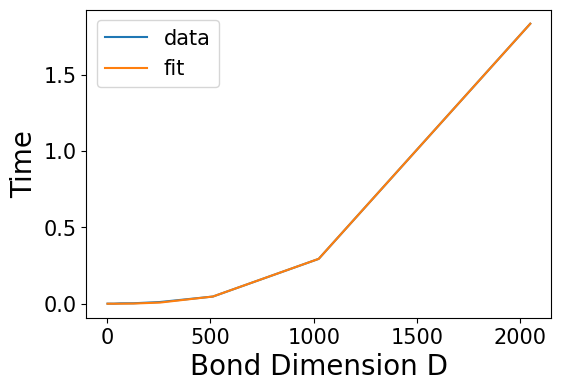

In [82]:
popt, pcov = curve_fit(f, x, T, maxfev=99999)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(pcov)
print(perr)

plt.plot(x, T, label="data")
plt.plot(x, f(x, *popt), label="fit")
plt.legend()
plt.xlabel("Bond Dimension D")
plt.ylabel(f"Time")